# Disability-free life expectancy

### Importing the relevant packages. Some may now be obsolete. 

In [7]:
import numpy as np

from src.unifiedsplines import UnifiedSplines

import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.backends.backend_pdf import PdfPages

from tqdm import tqdm

import seaborn as sns
sns.set_style("whitegrid")

import copy

import pickle

### Loading and checking the data

In [8]:
### Original dataset
df = pd.read_stata("data/in/data_in_python.dta")
df["wave"] = 8


###TEMPFIX to use the new data
varskeep = list(df) 
df = pd.read_stata("data/in/data_in_python.dta")
df = df[varskeep]
df["wave"] = df["wave"].fillna(1)
df["wave"] = df["wave"].astype(int)

### Common to both data
df["household"] = df["mergeid"].apply(lambda x : x[:-3])
df["indiv"] = df["mergeid"].apply(lambda x : int(x[-2:]))

#df

#df.dropna(inplace = True)
#df = df.head(10)

df
#df.reset_index(inplace=True)

,mergeid,palive0,palive1,palive2,palive3,palive4,varknot0,varknot1,varknot2,varknot3,varknot4,pjoint0,pjoint1,pjoint2,pjoint3,pjoint4,wave,household,indiv
0,F1-003061-02,1.0,1.00,1.0,0.8,0.0,0.0,5.0,10.0,20.0,40.0,1.0,1.0000,1.000,0.80,0.0,8,F1-003061,2
1,F1-007217-01,1.0,1.00,0.2,0.1,0.0,0.0,5.0,10.0,20.0,29.0,1.0,1.0000,0.200,0.09,0.0,8,F1-007217,1
2,F1-010108-01,1.0,1.00,0.7,0.3,0.0,0.0,5.0,10.0,20.0,33.0,1.0,0.5000,0.350,0.06,0.0,8,F1-010108,1
3,F1-010305-01,0.0,0.00,0.0,0.0,0.0,0.0,5.0,10.0,20.0,44.0,0.0,0.0000,0.000,0.00,0.0,8,F1-010305,1
4,F1-010305-02,1.0,1.00,0.5,0.1,0.0,0.0,5.0,10.0,20.0,39.0,1.0,1.0000,0.400,0.00,0.0,8,F1-010305,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,FR-988453-02,1.0,1.00,1.0,1.0,0.0,0.0,5.0,10.0,20.0,44.0,1.0,0.9000,0.800,0.20,0.0,9,FR-988453,2
2514,FR-988662-01,1.0,0.05,0.6,0.8,0.0,0.0,5.0,10.0,20.0,30.0,1.0,0.0475,0.300,0.16,0.0,9,FR-988662,1
2515,FR-988811-01,1.0,1.00,0.9,0.5,0.0,0.0,5.0,10.0,20.0,26.0,1.0,0.9500,0.810,0.35,0.0,9,FR-988811,1
2516,FR-993269-02,1.0,1.00,0.5,0.2,0.0,0.0,5.0,10.0,20.0,44.0,1.0,0.9000,0.425,0.06,0.0,9,FR-993269,2


### Looping over the individual in df and estimating the curves. 

This could probably use iterrows, but speed gain would be minimal. 

100%|█████████████████████████████████████| 2518/2518 [4:04:55<00:00,  5.84s/it]


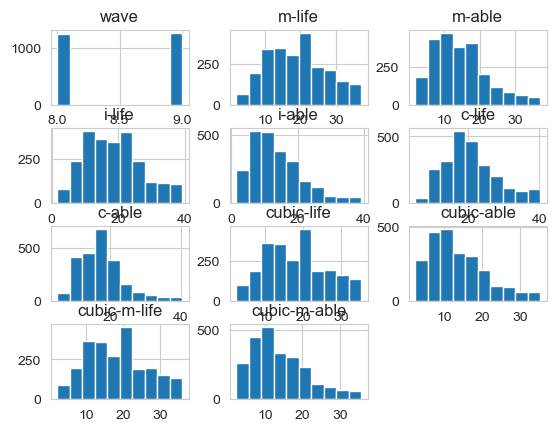

In [9]:
import os, copy, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

os.makedirs("graph", exist_ok=True)
os.makedirs("data/splines", exist_ok=True)
os.makedirs("data/out", exist_ok=True)

ppm = PdfPages('graph/m-splines.pdf')
ppi = PdfPages('graph/i-splines.pdf')
ppc = PdfPages('graph/c-splines.pdf')

ppBBK = PdfPages('graph/cubic-splines.pdf')
ppBBKh = PdfPages('graph/cubic-hyman-splines.pdf')

exportres = {}

ndraws = len(df)

# Load necessary data columns in advance
knot_data = df[[col for col in df.columns if "knot" in col.lower()]].values.astype(float)
palive_data = df[[col for col in df.columns if "palive" in col.lower()]].values.astype(float)  # S_live(t)
pjoint_data = df[[col for col in df.columns if "pjoint" in col.lower()]].values.astype(float)  # S_able(t) comme ton usage hazard
merge_ids = df["mergeid"].values

def clean_and_sort(knots_full, p_full):
    """Nettoie NaN, coupe au premier p==0, trie par knots. Retourne (knots, p) ou (None, None)."""
    valid = ~np.isnan(p_full)
    knots = knots_full[valid].astype(float)
    p = p_full[valid].astype(float)

    if knots.size < 2 or np.unique(knots).size < 2:
        return None, None

    # Coupe au premier 0 de survie (=> incidence = 1). Comportement conservé de ton code.
    if np.any(p == 0):
        zero_index = np.where(p == 0)[0][0]
        knots = knots[:zero_index + 1]
        p = p[:zero_index + 1]
        if knots.size < 2 or np.unique(knots).size < 2:
            return None, None

    # Tri
    order = np.argsort(knots)
    return knots[order], p[order]

for row in tqdm(range(ndraws)):
    uid = df.loc[row, "mergeid"]
    wave = df.loc[row, "wave"]

    savedsplines = {}

    knotvec_full = knot_data[row]
    probvec_full = palive_data[row]   # survie
    probablevec_full = pjoint_data[row]  # survie "able"

    # --- Nettoyage live / able ---
    knotvec, probvec = clean_and_sort(knotvec_full, probvec_full)
    knotablevec, probablevec = clean_and_sort(knotvec_full.copy(), probablevec_full)

    uidres = [wave]

    # Si pas assez de points, on remplit en NaN (structure exportres inchangée)
    if knotvec is None or knotablevec is None:
        uidres += [np.nan] * (2 * (3 + 2))  # 3 (M/I/C) + 2 (cubic no-hyman / hyman)
        exportres[f"{uid}_wave{wave}"] = uidres
        continue

    # --- Incidence (croissante) ---
    incvec = 1.0 - probvec           # F_live(t)
    incablevec = 1.0 - probablevec   # F_able(t)

    # --- Spline objects (MIC) ---
    myspline = UnifiedSplines(x=knotvec, knotval=knotvec, k=3)
    mysplineable = UnifiedSplines(x=knotablevec, knotval=knotablevec, k=3)

    # --- grids ---
    lstx = np.linspace(0, float(knotvec[-1]), num=50, endpoint=True)
    lstablex = np.linspace(0, float(knotablevec[-1]), num=50, endpoint=True)
    dx_live = lstx[1] - lstx[0]
    dx_able = lstablex[1] - lstablex[0]

    # ===== MIC types of splines (fit sur incidence) =====
    for splinetype in "MIC":

        # LIVE: fit incidence -> survivance -> intégrale
        myspline.fitsplinereg(knotvec, incvec, splinetype)
        inc_hat = myspline.evaluate(lstx, splinetype)
        inc_hat = np.clip(inc_hat, 0.0, 1.0)
        surv_hat = 1.0 - inc_hat
        lifeapprox = np.sum(dx_live * surv_hat)

        savedsplines[(splinetype, "live")] = copy.deepcopy(myspline)

        # ABLE: fit incidence -> survivance -> intégrale
        mysplineable.fitsplinereg(knotablevec, incablevec, splinetype)
        inc_hat_a = mysplineable.evaluate(lstablex, splinetype)
        inc_hat_a = np.clip(inc_hat_a, 0.0, 1.0)
        surv_hat_a = 1.0 - inc_hat_a
        ableapprox = np.sum(dx_able * surv_hat_a)

        # (bugfix) copier mysplineable, pas myspline
        savedsplines[(splinetype, "able")] = copy.deepcopy(mysplineable)

        uidres.append(lifeapprox)
        uidres.append(ableapprox)

        # ===== PLOTS =====
        f, axarr = plt.subplots(1, 2, sharex=False)
        title = f"{uid}: {splinetype}-spline (life exp. = {lifeapprox:.3f}, able exp. = {ableapprox:.3f})"
        f.suptitle(title, size=16)
        f.set_size_inches(10, 6)

        # gauche: incidence observée vs spline
        axarr[0].plot(knotvec, incvec, 'o', lstx, inc_hat, '-')
        axarr[0].plot(knotablevec, incablevec, 'o', lstablex, inc_hat_a, '--')
        axarr[0].set_title("Incidence (1 - p)")
        axarr[0].set_ylim(-0.02, 1.05)

        # droite: survie observée vs survie prédite (1-inc_hat)
        axarr[1].plot(knotvec, probvec, 'o', lstx, surv_hat, '-')
        axarr[1].plot(knotablevec, probablevec, 'o', lstablex, surv_hat_a, '--')
        axarr[1].set_title("Survival p = 1 - incidence")
        axarr[1].set_ylim(-0.02, 1.05)

        plt.tight_layout()
        plt.subplots_adjust(top=0.88)

        if splinetype == "M":
            ppm.savefig()
        elif splinetype == "I":
            ppi.savefig()
        elif splinetype == "C":
            ppc.savefig()

        plt.close()

    # ===== BBK types of splines (cubic) : fit sur incidence =====
    for hyman in [False, True]:
        # LIVE
        splinelive_h = UnifiedSplines(x=knotvec, y=incvec, apply_hyman_filter=hyman)
        inc_hat = splinelive_h.evaluate(lstx)
        inc_hat = np.clip(inc_hat, 0.0, 1.0)
        surv_hat = 1.0 - inc_hat
        lifeapprox = np.sum(dx_live * surv_hat)

        savedsplines[(f"cubic-{hyman}", "live")] = copy.deepcopy(splinelive_h)

        # ABLE
        splineable_h = UnifiedSplines(x=knotablevec, y=incablevec, apply_hyman_filter=hyman)
        inc_hat_a = splineable_h.evaluate(lstablex)
        inc_hat_a = np.clip(inc_hat_a, 0.0, 1.0)
        surv_hat_a = 1.0 - inc_hat_a
        ableapprox = np.sum(dx_able * surv_hat_a)

        # (bugfix) stocker en 'able', pas 'live'
        savedsplines[(f"cubic-{hyman}", "able")] = copy.deepcopy(splineable_h)

        uidres.append(lifeapprox)
        uidres.append(ableapprox)

        # plots
        f, axarr = plt.subplots(1, 2, sharex=False)
        title = f"{uid}: cubic-spline (Hyman : {hyman}) (life exp. = {lifeapprox:.3f}, able exp. = {ableapprox:.3f})"
        f.suptitle(title, size=16)
        f.set_size_inches(10, 6)

        axarr[0].plot(knotvec, incvec, 'o', lstx, inc_hat, '-')
        axarr[0].plot(knotablevec, incablevec, 'o', lstablex, inc_hat_a, '--')
        axarr[0].set_title("Incidence (1 - p)")
        axarr[0].set_ylim(-0.02, 1.05)

        axarr[1].plot(knotvec, probvec, 'o', lstx, surv_hat, '-')
        axarr[1].plot(knotablevec, probablevec, 'o', lstablex, surv_hat_a, '--')
        axarr[1].set_title("Survival p = 1 - incidence")
        axarr[1].set_ylim(-0.02, 1.05)

        plt.tight_layout()
        plt.subplots_adjust(top=0.88)

        if hyman:
            ppBBKh.savefig()
        else:
            ppBBK.savefig()

        plt.close()

    exportres[f"{uid}_wave{wave}"] = uidres

    # Dumping the spline dict in a pickle file for future use.
    with open(f"data/splines/s_{uid}-{wave}.pkl", "wb") as f:
        pickle.dump(savedsplines, f)

# Close PDFs (en dehors de la boucle)
ppm.close()
ppi.close()
ppc.close()
ppBBK.close()
ppBBKh.close()

# ===== Export results table =====
dfout = pd.DataFrame(exportres).T
dfout.reset_index(inplace=True)
dfout.rename(columns={'index': 'unique_id'}, inplace=True)

spline_cols = [
    "wave",
    "m-life", "m-able",
    "i-life", "i-able",
    "c-life", "c-able",
    "cubic-life", "cubic-able",       # hyman=False
    "cubic-m-life", "cubic-m-able"    # hyman=True
]
dfout.columns = ["unique_id"] + spline_cols

dfout.to_csv("data/out/predict_on_proba.csv", float_format="%.6f", index=False)

# quick hist
dfout[list(dfout)[1:]].hist()
plt.show()

<Axes: xlabel='cubic-life', ylabel='c-life'>

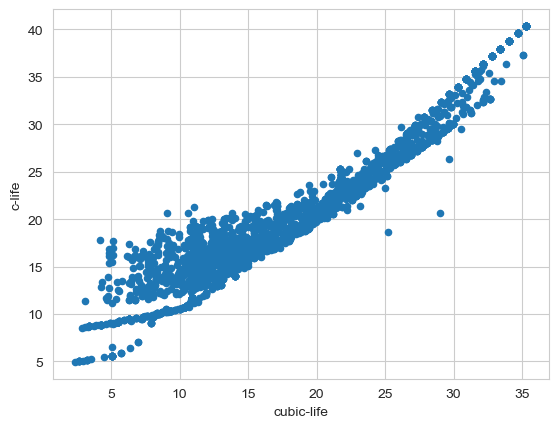

In [10]:
df = pd.read_stata("data/in/data_in_python.dta")

df["household"] = df["mergeid"].apply(lambda x : x[:-3])
df["indiv"] = df["mergeid"].apply(lambda x : int(x[-2:]))

df.head()


df2 = pd.read_csv("data/out/predict_on_proba.csv")
df2[list(df2)[1:]].corr()
df2.plot.scatter(x="cubic-life", y="c-life")